<a href="https://colab.research.google.com/github/deepankar5/-Triplet-Extractor-from-Wikipedia-page/blob/main/triple_extaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
%pip install Wikipedia-API

  Created wheel for Wikipedia-API: filename=Wikipedia_API-0.5.4-cp36-none-any.whl size=13462 sha256=37d3e1fff56db2e2a8efe09903ae33708fc12349aa40ad79941074d2c66aef9e
  Stored in directory: /root/.cache/pip/wheels/bf/40/42/ba1d497f3712281b659dd65b566fc868035c859239571a725a
Successfully built Wikipedia-API


In [14]:
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia(
        language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI
)

p_wiki = wiki_wiki.page("Thor")
print(p_wiki.text)

In Germanic mythology, Thor (; from Old Norse: Þórr) is a hammer-wielding god associated with lightning, thunder, storms, sacred groves and trees, strength, the protection of mankind and also hallowing and fertility. Besides Old Norse Þórr, extensions of the god occur in Old English as Þunor and in Old High German as Donar. All forms of the deity stem from a Common Germanic *Þunraz (meaning 'thunder'). 
Thor is a prominently mentioned god throughout the recorded history of the Germanic peoples, from the Roman occupation of regions of Germania, to the Germanic expansions of the Migration Period, to his high popularity during the Viking Age, when, in the face of the process of the Christianization of Scandinavia, emblems of his hammer, Mjölnir, were worn and Norse pagan personal names containing the name of the god bear witness to his popularity.
Due to the nature of the Germanic corpus, narratives featuring Thor are only attested in Old Norse, where Thor appears throughout Norse mytholo

In [15]:
import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt

def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip().replace('\n', " ") for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

In [16]:
import pandas as pd

sentences = getSentences(p_wiki.text)
triples = []

for sentence in sentences:
    triples.append(processSentence(sentence))

relations_table = pd.DataFrame(triples, index = range(0, len(triples)), columns = ['Subject', 'Relation', 'Object'])

Streaming output truncated to the last 5000 lines.
Týr -> nsubj
sees -> conj
his -> poss
nine -> compound
- -> punct
hundred -> npadvmod
- -> punct
headed -> amod
grandmother -> dobj
and -> cc
his -> poss
gold -> npadvmod
- -> punct
clad -> amod
mother -> conj
, -> punct
the -> det
latter -> nsubj
of -> prep
which -> pobj
welcomes -> relcl
them -> dobj
with -> prep
a -> det
horn -> pobj
. -> punct
They Týr latter , arrive head clothe , grandmother which them horn
After -> prep
Hymir -> pobj
— -> punct
who -> nsubj
is -> relcl
not -> neg
happy -> acomp
to -> aux
see -> xcomp
Thor -> dobj
— -> punct
comes -> advcl
in -> prt
from -> prep
the -> det
cold -> amod
outdoors -> pobj
, -> punct
Týr -> poss
's -> case
mother -> nsubj
helps -> ROOT
them -> nsubj
find -> ccomp
a -> det
properly -> advmod
strong -> amod
cauldron -> dobj
. -> punct
who mother them , cold help strong , Hymir Thor outdoors cauldron
Thor -> nsubj
eats -> ROOT
a -> det
big -> amod
meal -> dobj
of -> prep
two -> nummod
o

In [17]:
relations_table.to_csv('relation_table.csv')

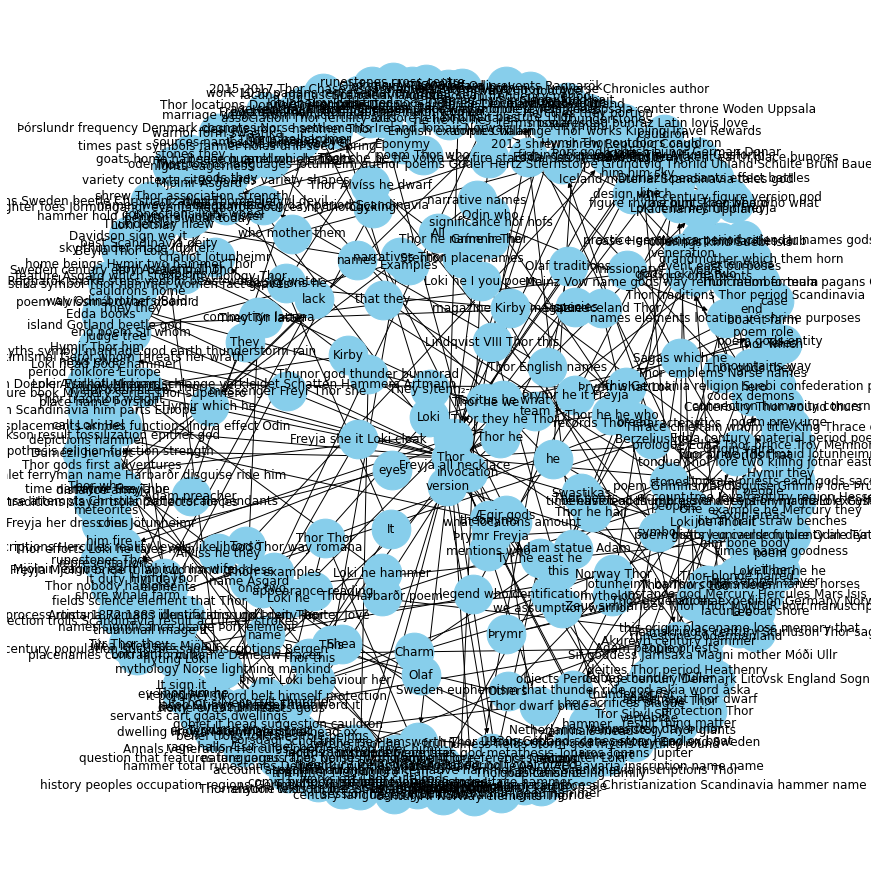

In [18]:
%matplotlib inline
G=nx.from_pandas_edgelist(relations_table, "Subject", "Object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()